In [3]:
from bs4 import BeautifulSoup
import urllib.request
import pandas as pd
import datetime
from selenium import webdriver
import time
import requests
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

#그래프의 축 등에서 음수를 표시할 때 minus sign이 깨지는 것 해결
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

C:\Users\user\AppData\Local\Temp\ipykernel_7192\2025618107.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [15]:
default_URL = "https://www.wanted.co.kr/salary/"
wd = webdriver.Chrome()
occs = {'개발' : '518', '경영·비즈니스': '507', '마케팅·광고': '523', '디자인': '511', '영업': '530', '고객서비스·리테일': '510',
        '미디어':'524', 'HR':'517', '금융':'508', '제조·생산':'522', '교육': '10101',
        '의료·제약·바이오':'515'} #주소 뒤의 숫자값
totaldf = pd.DataFrame(columns = ['직군', '직무', '신입', '1년차', '2년차', '3년차' ,'4년차', '5년차', '6년차', '7년차', '8년차', '9년차', '10년차'])
occname = list(occs.keys())
dfnum = 0 #데이터프레임 인덱스값

for h in range(len(occs)): # 직군만큼 반복
    URL = default_URL + occs[occname[h]]
    wd.get(URL)
    time.sleep(2) #과부화 방지
    html = wd.page_source
    wanted = BeautifulSoup(html, 'html.parser')
    jobshtml = wanted.select('div > div > select > option') #직군, 직업, 경력 모두 나옴
    jobs = jobshtml[20:-12] #직업만 뽑아내고 싶은데, 직군이랑 경력의 갯수는 바뀌지 않으므로 직군 20개와 경력 12개 제거
    jobvalue = {} #딕셔너리 초기화
    for g in range(len(jobs)): #직업 갯수만큼 반복
        jobname = jobs[g].string #직업 이름 추출
        a = str(jobs[g]) #value값을 뽑으려 split하기 위해 option~구문을 문자열화
        b = a.split('value="', 1)[1] #value값의 앞까지 한번만 분할, 뒤의내용 추출
        value = b.split('">',1)[0] #value값 이후부터 한번만 분할, 앞의내용 추출
        jobvalue[jobname] = value #직업 이름 key값에 주소 뒤의 숫자인 value값 저장
    jobnames = list(jobvalue.keys()) #key만 따로 리스트로 분할
  
    for k in range(len(jobvalue)): #직업만큼 반복
        if jobvalue[jobnames[k]] == '0': #직업이 value값 0인 '전체' 일시에
            URL = default_URL + occs[occname[h]] #직군 자체의 value값으로 주소 할당 (0으로 할시 나오지 않음)
        else:
            URL = default_URL + jobvalue[jobnames[k]] #직군의 value값으로 설정
        
        wd.get(URL) #직군값이 들어가있는 해당 URL을 get
        time.sleep(3) #과부화 방지
        html = wd.page_source
        wanted = BeautifulSoup(html, 'html.parser')
        #연봉값을 가져오고 싶은데, 연봉 값이 페이지 안에 저장이 되어있지 않음
        #대신에 그래프 높이는 저장되어 있으므로, 그래프 폼의 y축 최댓값과 각 그래프의 높이를 비교하여 연봉값을 추출
        try:
            fullheight = wanted.select('defs > clipPath > rect') #그래프 폼 부분
            full_height = float(fullheight[0].get('height'))  #문자열로 되어있는 그래프 폼의 높이 값을 계산을 위해 float로 추출
        except: #페이지가 로드가 잘못되었을 경우
            wd.get(URL) #다시 전의 URL을 지정, 연결
            time.sleep(3) #과부화 방지
            html = wd.page_source
            wanted = BeautifulSoup(html, 'html.parser')
            fullheight = wanted.select('defs > clipPath > rect') #위의 코드와 동일
            full_height = float(fullheight[0].get('height'))

        heighttotal = wanted.select('g > g > g > g > path') #각 그래프의 모든 높이값이 저장되어 있음 
        heights = [] #높이를 저장할 리스트 생성
        for l in range(11): #신입~10년차 까지 11개의 값(신입, 1~10년차)만큼 반복
            heights.append(float(heighttotal[l].get('height'))) #각 그래프의 높이값을 heights 리스트에 저장

        yheight = wanted.select('g > text > tspan') #그래프 폼의 y축(연봉) 최댓값을 추출
        yheight = int(yheight[-1].string.replace(',','')) #8,000 이런식으로 저장되어 있으므로 콤마제거 후 정수로 받음

        yearmoney = [] #신입~10년차까지의 연봉을 저장할 리스트 초기화

        for j in range(len(heights)): #신입~10년차까지의 높이 수 만큼 반복(11번)
            yearmoney.append(int((heights[j] * yheight)/full_height)) #yearmoney 리스트에 그래프의 높이와 최대값을 이용한 연봉 계산값을 소수점을 버려 int형으로 저장

        #totaldf라는 연봉 데이터 프레임에 dfnum 인덱스값으로 저장
        totaldf.loc[dfnum] = [occname[h], jobnames[k], yearmoney[0], yearmoney[1], yearmoney[2], yearmoney[3], yearmoney[4], yearmoney[5], yearmoney[6], yearmoney[7], yearmoney[8], yearmoney[9], yearmoney[10]]
        dfnum = dfnum + 1 #index값 증가



totaldf

    

,직군,직무,신입,1년차,2년차,3년차,4년차,5년차,6년차,7년차,8년차,9년차,10년차
0,개발,전체,3536,3694,3982,4317,4624,4819,5177,5499,5859,6185,7057
1,개발,데이터 엔지니어,3613,3772,4138,4558,4985,5041,5462,6054,6427,6514,7699
2,개발,임베디드 개발자,3516,3674,3831,4136,4651,4809,5120,5556,5713,6176,6917
3,개발,자바 개발자,3353,3599,3839,4203,4434,4747,5083,5226,5639,6015,6859
4,개발,.NET 개발자,2974,3287,3545,4004,4297,4418,4919,5123,5357,5591,6507
...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,의료·제약·바이오,한의사,3247,3359,3614,3869,4046,4208,4306,4403,4953,5196,5439
269,의료·제약·바이오,방사선사,3247,3359,3614,3869,4046,4208,4306,4403,4953,5196,5439
270,의료·제약·바이오,병원 코디네이터,3247,3359,3614,3869,4046,4208,4306,4403,4953,5196,5439
271,의료·제약·바이오,의무기록사,3247,3359,3614,3869,4046,4208,4306,4403,4953,5196,5439


In [16]:
totaldf.to_csv('totaldf.csv') #데이터프레임 csv로 저장

In [266]:
totaldf = pd.read_csv('totaldf.csv', index_col = 0)
#데이터 프레임에 신입~10년차까지 중복된 값들이 있으므로 중복해서 나오는 값들은 전부 제거
totaldf = totaldf.drop_duplicates(['신입', '1년차', '2년차', '3년차', '4년차', '5년차', '6년차', '7년차', '8년차', '9년차', '10년차'])
totaldf.reset_index(inplace=True, drop=True) #for문을 위해 인덱스 재정렬
totaldf

,직군,직무,신입,1년차,2년차,3년차,4년차,5년차,6년차,7년차,8년차,9년차,10년차
0,개발,전체,3536,3694,3982,4317,4624,4819,5177,5499,5859,6185,7057
1,개발,데이터 엔지니어,3613,3772,4138,4558,4985,5041,5462,6054,6427,6514,7699
2,개발,임베디드 개발자,3516,3674,3831,4136,4651,4809,5120,5556,5713,6176,6917
3,개발,자바 개발자,3353,3599,3839,4203,4434,4747,5083,5226,5639,6015,6859
4,개발,.NET 개발자,2974,3287,3545,4004,4297,4418,4919,5123,5357,5591,6507
...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,제조·생산,전체,2971,3195,3420,3731,3970,4119,4224,4382,4574,4766,4919
108,제조·생산,생산 관리자,2942,3109,3276,3443,3667,3891,4262,4334,4502,4671,4840
109,제조·생산,품질 관리자,2885,3392,3590,3629,3963,3982,4380,4450,4652,4916,5180
110,교육,전체,3047,3174,3435,3667,3671,3712,3754,3862,3971,4080,4559


In [128]:
totaldf['직군'].value_counts() == 1 #모든 중복값이 사라졌을때, '전체' 직무만 있는 직군들을 찾기

직군
개발           False
마케팅·광고       False
디자인          False
경영·비즈니스      False
HR           False
영업           False
미디어          False
고객서비스·리테일    False
제조·생산        False
금융            True
교육            True
의료·제약·바이오     True
Name: count, dtype: bool

In [142]:
alldata = totaldf[totaldf['직무'] == '전체'] #직군 전체의 연봉데이터만 추출
alldata.reset_index(inplace=True, drop=True) #for문을 위한 index 재정렬
alldata

,직군,직무,신입,1년차,2년차,3년차,4년차,5년차,6년차,7년차,8년차,9년차,10년차
0,개발,전체,3536,3694,3982,4317,4624,4819,5177,5499,5859,6185,7057
1,경영·비즈니스,전체,3324,3371,3646,3973,4169,4452,4746,4976,5253,5816,6752
2,마케팅·광고,전체,2898,3111,3510,3652,3980,4153,4358,4689,4959,5374,6177
3,디자인,전체,2843,3005,3196,3416,3635,3877,4048,4232,4507,4712,5284
4,영업,전체,3030,3385,3532,3900,4133,4318,4572,4677,5266,5499,6047
5,고객서비스·리테일,전체,2770,2890,3103,3358,3420,3672,3931,3961,4131,4316,4697
6,미디어,전체,2824,3011,3176,3518,3603,3791,3997,4037,4409,4712,5089
7,HR,전체,3199,3371,3487,3761,4058,4299,4532,4785,5054,5473,6758
8,금융,전체,2961,3283,4427,4494,4929,4979,5030,5779,6370,6551,7998
9,제조·생산,전체,2971,3195,3420,3731,3970,4119,4224,4382,4574,4766,4919


C:\Users\user\AppData\Local\Temp\ipykernel_7192\1640547780.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alldata['분산'] = [alldata.iloc[0,2:].std(), alldata.iloc[1,2:].std(), alldata.iloc[2,2:].std(), alldata.iloc[3,2:].std(), alldata.iloc[4,2:].std(),
C:\Users\user\AppData\Local\Temp\ipykernel_7192\1640547780.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(alldatamoney.columns, alldatamoney.loc[k], color_and_line[k], label=alldata.loc[k][0])


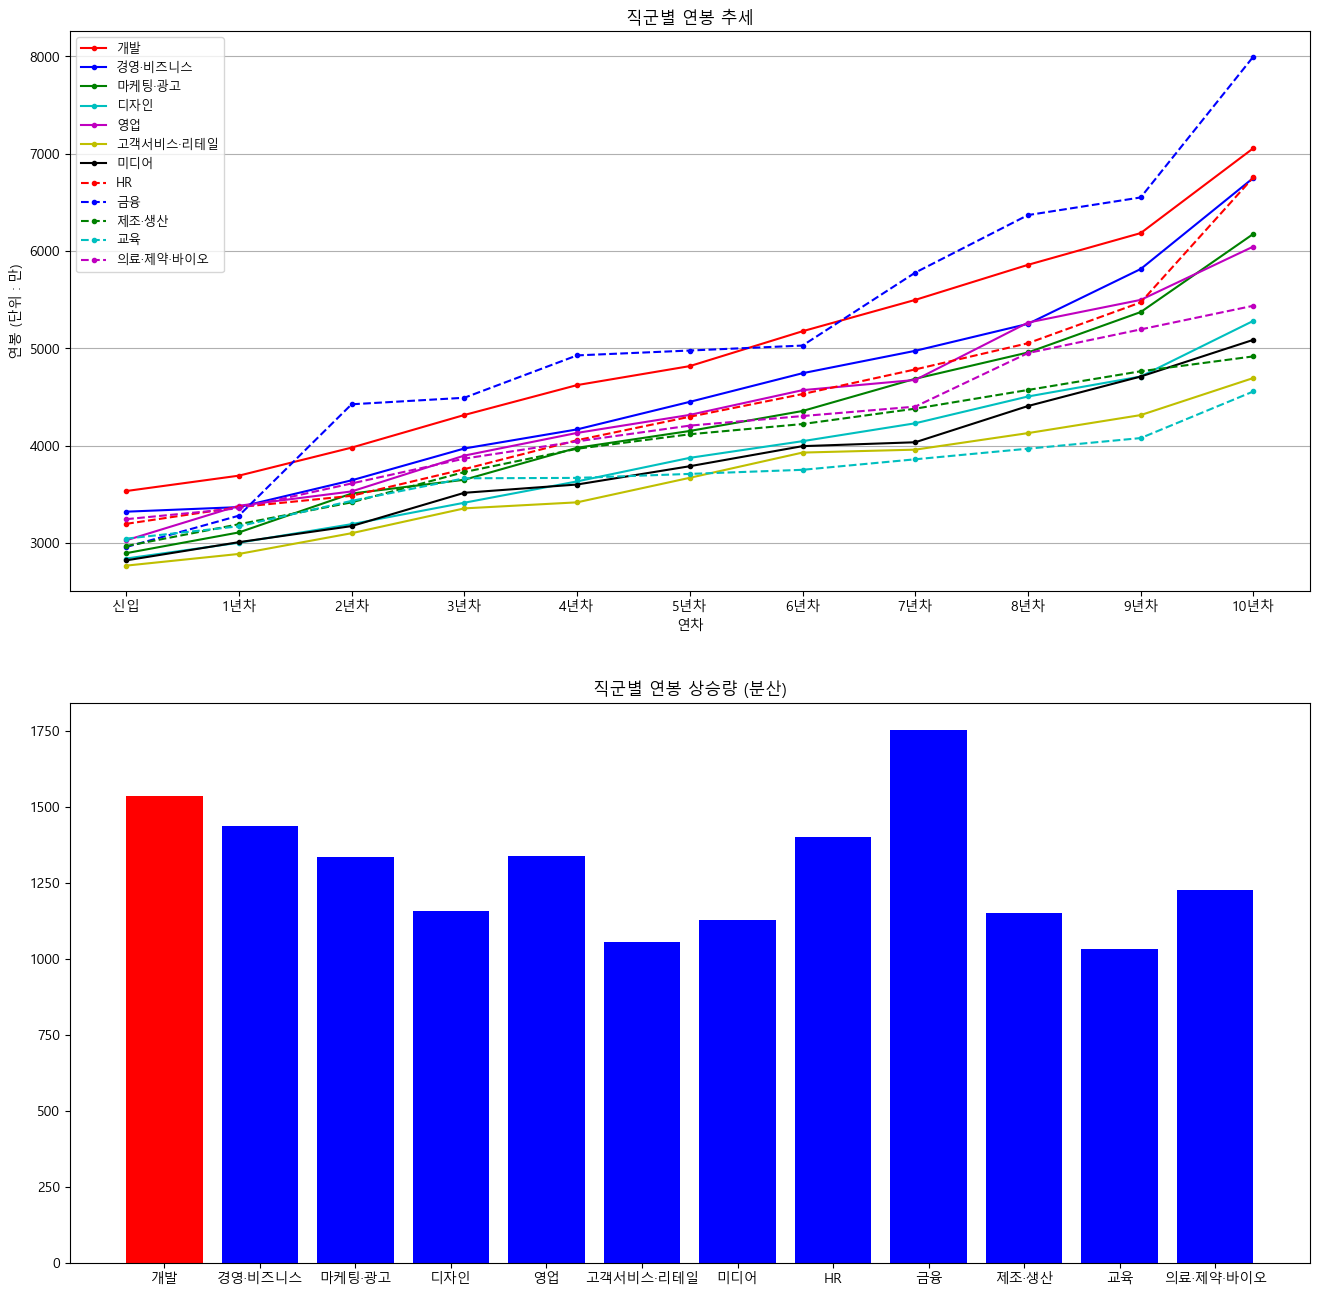

In [270]:
#직군 전체만 뽑은 데이터에 신입~10년차까지 연봉의 분산데이터를 추가
alldata['분산'] = [alldata.iloc[0,2:].std(), alldata.iloc[1,2:].std(), alldata.iloc[2,2:].std(), alldata.iloc[3,2:].std(), alldata.iloc[4,2:].std(),
                 alldata.iloc[5,2:].std(), alldata.iloc[6,2:].std(), alldata.iloc[7,2:].std(), alldata.iloc[8,2:].std(), alldata.iloc[9,2:].std(),
                 alldata.iloc[10,2:].std(), alldata.iloc[11,2:].std()]

alldatamoney = alldata.iloc[:,2:13] #신입~10년차까지의 연봉 데이터
color_and_line = ['r.-', 'b.-', 'g.-', 'c.-', 'm.-', 'y.-', 'k.-', 'r.--', 'b.--', 'g.--', 'c.--', 'm.--']

plt.figure(figsize=(16,16))

plt.subplot(2, 1, 1)
plt.title("직군별 연봉 추세")
plt.xlabel('연차')
plt.ylabel('연봉 (단위 : 만)')
for k in range(len(alldata)):
    plt.plot(alldatamoney.columns, alldatamoney.loc[k], color_and_line[k], label=alldata.loc[k][0])
plt.legend(fontsize=9)
plt.grid(True, axis = 'y')

plt.subplot(2, 1, 2)
plt.title("직군별 연봉 상승량 (분산)")
plt.bar(alldata['직군'], alldata['분산'], color = ['red', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue'])

plt.show()

In [267]:
#'전체'직무만 있는 직군들을 따로 정의
df1 = totaldf[totaldf['직군'] == '금융']
df2 = totaldf[totaldf['직군'] == '교육']
df3 = totaldf[totaldf['직군'] == '의료·제약·바이오']

#직군 전체를 딴 데이터들을 제거 (직무별로 나뉘어진 데이터만 추출)
#대신 위의 데이터 세 프레임은 전체 직무만 있고, 전체 직무를 삭제하면 직군이 사라지게 되므로 따로 포함
totaldf_no_all = pd.concat([totaldf[totaldf['직무'] != '전체'], df1, df2, df3])
totaldf_no_all.reset_index(inplace=True, drop=True) #for문을 위한 index 재정렬
totaldf_no_all

,직군,직무,신입,1년차,2년차,3년차,4년차,5년차,6년차,7년차,8년차,9년차,10년차
0,개발,데이터 엔지니어,3613,3772,4138,4558,4985,5041,5462,6054,6427,6514,7699
1,개발,임베디드 개발자,3516,3674,3831,4136,4651,4809,5120,5556,5713,6176,6917
2,개발,자바 개발자,3353,3599,3839,4203,4434,4747,5083,5226,5639,6015,6859
3,개발,.NET 개발자,2974,3287,3545,4004,4297,4418,4919,5123,5357,5591,6507
4,개발,"시스템,네트워크 관리자",3470,3546,3632,4083,4316,4461,5038,5374,5518,5921,6654
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,제조·생산,생산 관리자,2942,3109,3276,3443,3667,3891,4262,4334,4502,4671,4840
99,제조·생산,품질 관리자,2885,3392,3590,3629,3963,3982,4380,4450,4652,4916,5180
100,금융,전체,2961,3283,4427,4494,4929,4979,5030,5779,6370,6551,7998
101,교육,전체,3047,3174,3435,3667,3671,3712,3754,3862,3971,4080,4559


C:\Users\user\AppData\Local\Temp\ipykernel_7192\2785856235.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lowlabels = newmoneylow.loc[k][0] + ' - ' + newmoneylow.loc[k][1] #직군 - 직무로 이어진 문자열 생성
C:\Users\user\AppData\Local\Temp\ipykernel_7192\2785856235.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  highlabels = newmoneyhigh.loc[k][0] + ' - ' + newmoneyhigh.loc[k][1] #직군 - 직무로 이어진 문자열 생성
C:\Users\user\AppData\Local\Temp\ipykernel_7192\2785856235.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent wi

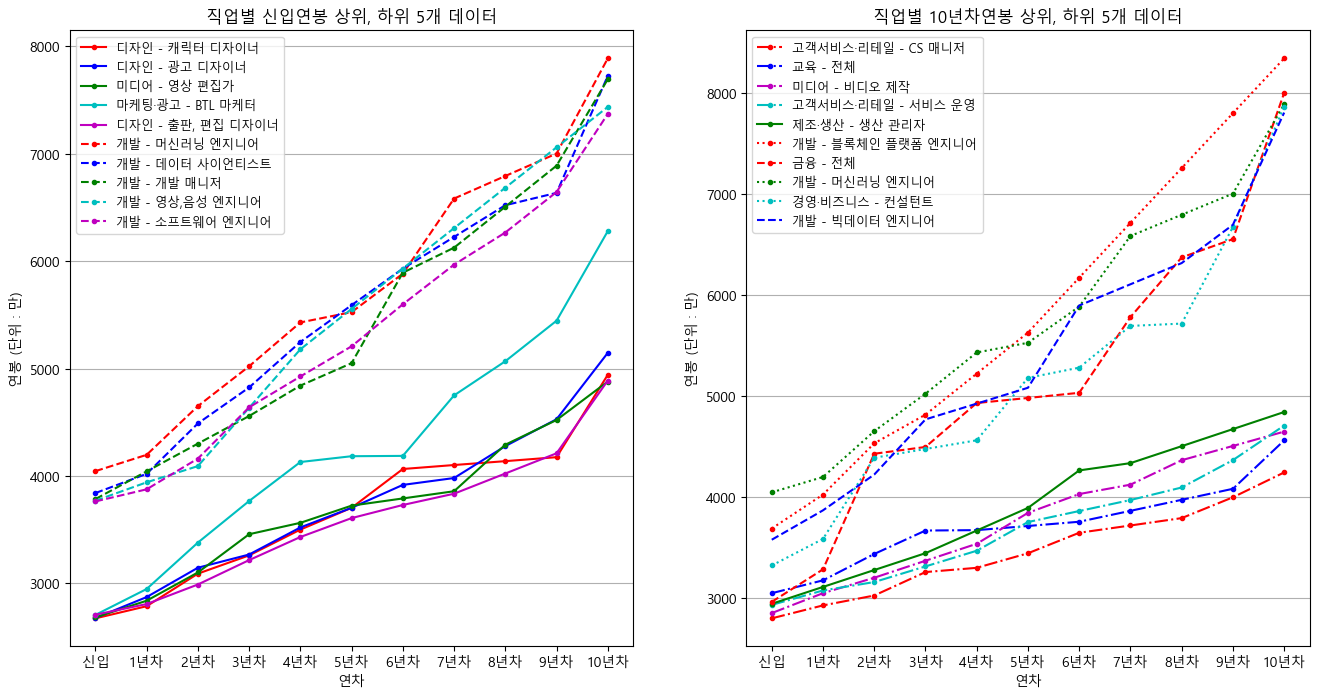

In [269]:
newmoneylow = totaldf_no_all.sort_values('신입')[:5] #신입 연봉 금액의 하위 5개
newmoneylow.reset_index(inplace=True, drop=True) #for문을 위한 index 재정렬
newmoneyhigh = totaldf_no_all.sort_values('신입', ascending=False)[:5] #신입 연봉 금액의 상위 5개
newmoneyhigh.reset_index(inplace=True, drop=True) #for문을 위한 index 재정렬
oldmoneylow = totaldf_no_all.sort_values('10년차')[:5] #10년차 연봉 금액의 하위 5개
oldmoneylow.reset_index(inplace=True, drop=True) #for문을 위한 index 재정렬
oldmoneyhigh = totaldf_no_all.sort_values('10년차', ascending=False)[:5] #10년차 연봉 금액의 상위 5개
oldmoneyhigh.reset_index(inplace=True, drop=True) #for문을 위한 index 재정렬

#아래 데이터를 보고 두 그래프의 중복된 값들은 같은 색과 스타일로 지정, 나머지는 다 다르게
color_and_line = ['r.-', 'b.-', 'g.-', 'c.-', 'm.-', 'r.--', 'b.--', 'g.--', 'c.--', 'm.--']
color_and_line2 = ['r-..', 'b-..', 'm-..', 'c-..', 'g.-', 'r:.', 'r.--', 'g:.', 'c:.', 'b--']

plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
plt.title("직업별 신입연봉 상위, 하위 5개 데이터")
plt.xlabel('연차')
plt.ylabel('연봉 (단위 : 만)')

for k in range(len(newmoneylow)):
    lowlabels = newmoneylow.loc[k][0] + ' - ' + newmoneylow.loc[k][1] #직군 - 직무로 이어진 문자열 생성
    plt.plot(newmoneylow.iloc[:, 2:].columns, newmoneylow.iloc[:, 2:].loc[k], color_and_line[k], label=lowlabels)
for k in range(len(newmoneyhigh)):
    highlabels = newmoneyhigh.loc[k][0] + ' - ' + newmoneyhigh.loc[k][1] #직군 - 직무로 이어진 문자열 생성
    plt.plot(newmoneyhigh.iloc[:, 2:].columns, newmoneyhigh.iloc[:, 2:].loc[k], color_and_line[k+5], label=highlabels)
plt.legend(fontsize=9)
plt.grid(True, axis = 'y')

plt.subplot(1, 2, 2)
plt.title("직업별 10년차연봉 상위, 하위 5개 데이터")
plt.xlabel('연차')
plt.ylabel('연봉 (단위 : 만)')

for k in range(len(oldmoneylow)):
    lowlabels = oldmoneylow.loc[k][0] + ' - ' + oldmoneylow.loc[k][1] #직군 - 직무로 이어진 문자열 생성
    plt.plot(oldmoneylow.iloc[:, 2:].columns, oldmoneylow.iloc[:, 2:].loc[k], color_and_line2[k], label=lowlabels)
for k in range(len(oldmoneyhigh)):
    highlabels = oldmoneyhigh.loc[k][0] + ' - ' + oldmoneyhigh.loc[k][1] #직군 - 직무로 이어진 문자열 생성
    plt.plot(oldmoneyhigh.iloc[:, 2:].columns, oldmoneyhigh.iloc[:, 2:].loc[k], color_and_line2[k+5], label=highlabels)
plt.legend(fontsize=9)
plt.grid(True, axis = 'y')

plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_7192\2841414589.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lowlabels = stddevdf_low.loc[k][0] + ' - ' + stddevdf_low.loc[k][1]
C:\Users\user\AppData\Local\Temp\ipykernel_7192\2841414589.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  highlabels = stddevdf_high.loc[k][0] + ' - ' + stddevdf_high.loc[k][1]


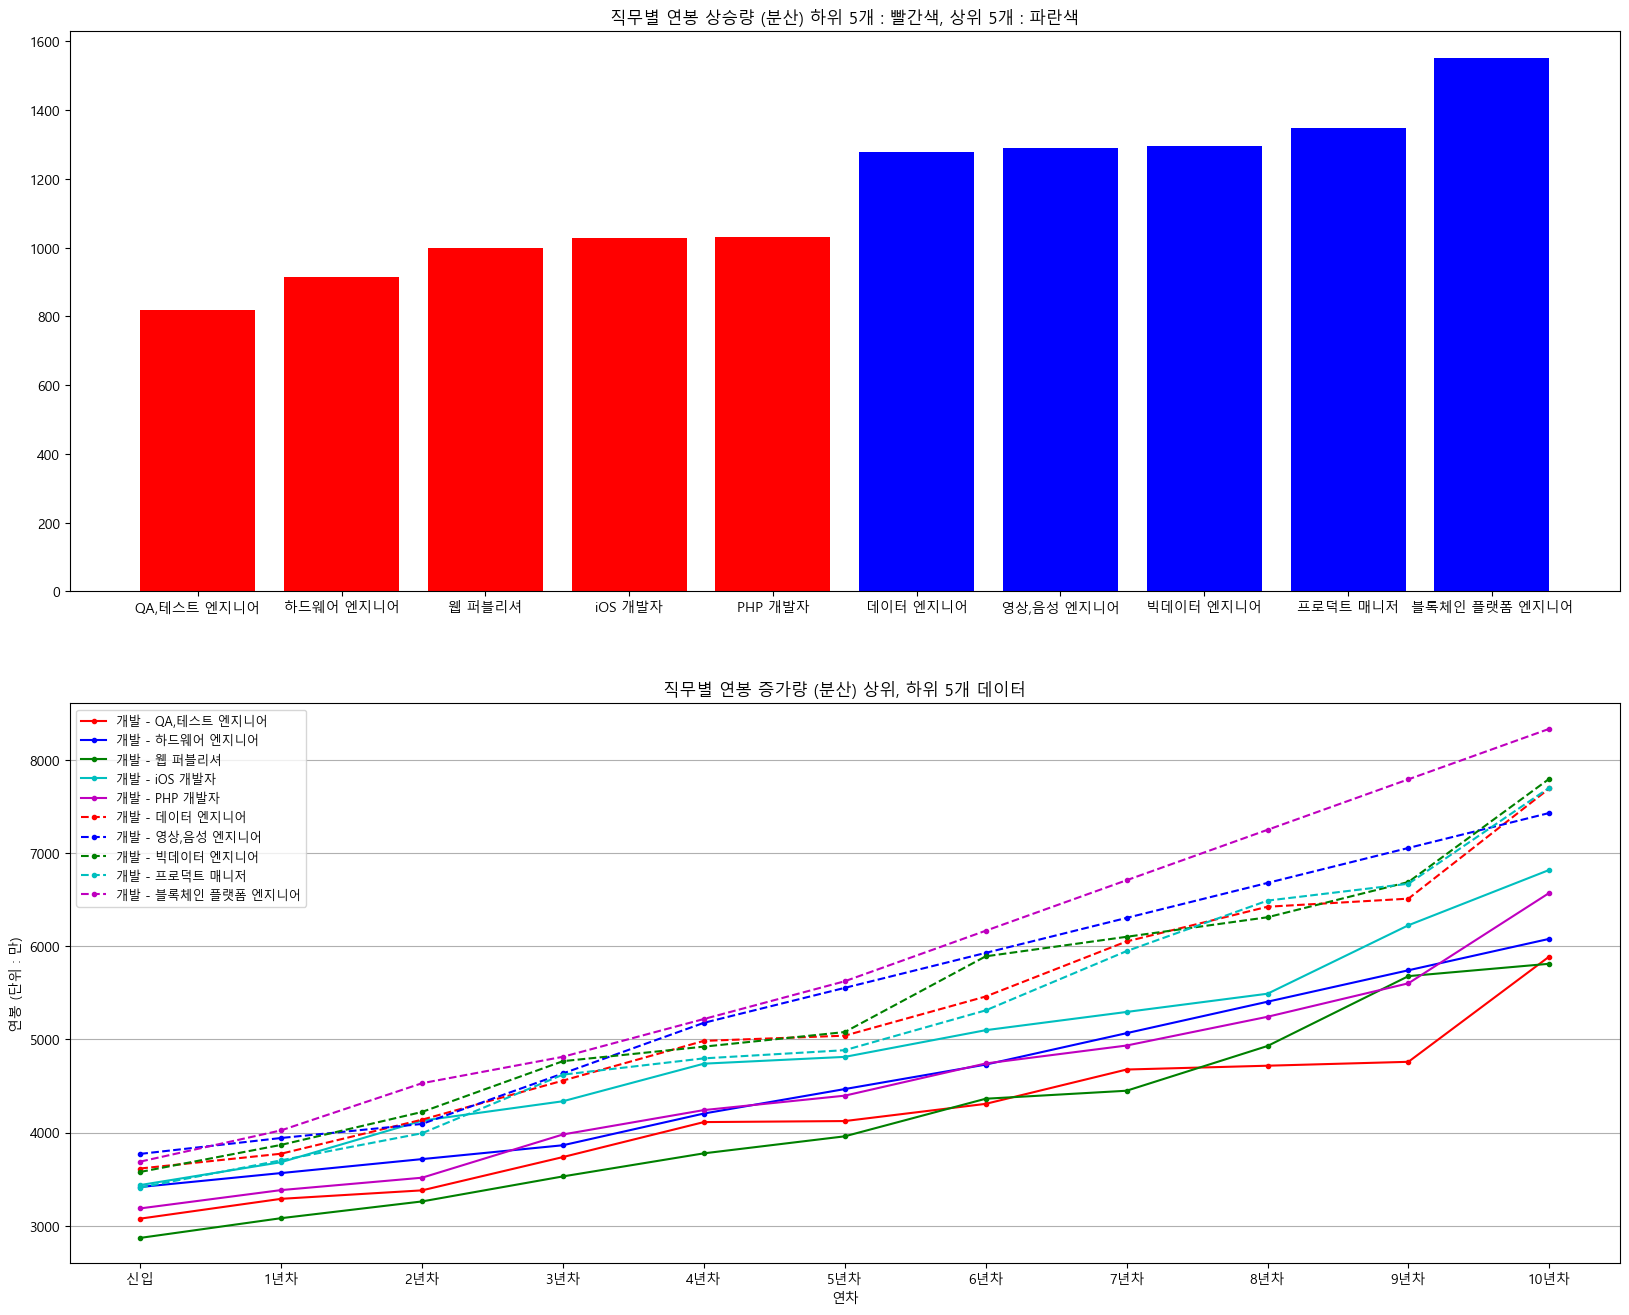

In [264]:
devdf = totaldf[totaldf['직군'] == '개발'] #개발 직군의 데이터만 추출
#인덱스 초기화를 안한 이유는 index=0부터 있었던 데이터였기 때문
devstd = [] #분산을 저장하기 위한 리스트
#분산값을 devstd 리스트에 저장 (개발 직군의 직무 수가 많아서 for문으로 처리)
for k in range(len(devdf)):
    devstd.append(devdf.iloc[k,2:].std()) #신입~10년차까지의 분산값

devdf['분산'] = devstd #devdf 데이터프레임에 분산값 추가

stddevdf = devdf.sort_values('분산') #분산값을 기준으로 데이터 정렬
stddevdf_low = stddevdf.iloc[:5, :]  #분산값 하위 5개 데이터 추출
stddevdf_low.reset_index(inplace=True, drop=True) #for문을 위한 index 재정렬
stddevdf_high = stddevdf.iloc[-5:, :] #분산값 상위 5개 데이터 추출
stddevdf_high.reset_index(inplace=True, drop=True) #for문을 위한 index 재정렬

color_and_line = ['r.-', 'b.-', 'g.-', 'c.-', 'm.-', 'r.--', 'b.--', 'g.--', 'c.--', 'm.--']

plt.figure(figsize=(20,16))

plt.subplot(2,1,1)
plt.title("직무별 연봉 상승량 (분산) 하위 5개 : 빨간색, 상위 5개 : 파란색")
plt.bar(stddevdf_low['직무'], stddevdf_low['분산'], color = ['red'])
plt.bar(stddevdf_high['직무'], stddevdf_high['분산'], color = ['blue'])

plt.subplot(2,1,2)
plt.title("직무별 연봉 증가량 (분산) 상위, 하위 5개 데이터")
plt.xlabel('연차')
plt.ylabel('연봉 (단위 : 만)')
for k in range(len(stddevdf_low)):
    lowlabels = stddevdf_low.loc[k][0] + ' - ' + stddevdf_low.loc[k][1] #직군 - 직무로 이어진 문자열 생성
    plt.plot(stddevdf_low.iloc[:, 2:13].columns, stddevdf_low.iloc[:, 2:13].loc[k], color_and_line[k], label=lowlabels)
for k in range(len(stddevdf_high)):
    highlabels = stddevdf_high.loc[k][0] + ' - ' + stddevdf_high.loc[k][1] #직군 - 직무로 이어진 문자열 생성
    plt.plot(stddevdf_high.iloc[:, 2:13].columns, stddevdf_high.iloc[:, 2:13].loc[k], color_and_line[k+5], label=highlabels)
plt.legend(fontsize=9)
plt.grid(True, axis = 'y')

plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_7192\2469388259.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lowlabels = newmoneylow.loc[k][0] + ' - ' + newmoneylow.loc[k][1] #직군 - 직무로 이어진 문자열 생성
C:\Users\user\AppData\Local\Temp\ipykernel_7192\2469388259.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  highlabels = newmoneyhigh.loc[k][0] + ' - ' + newmoneyhigh.loc[k][1] #직군 - 직무로 이어진 문자열 생성
C:\Users\user\AppData\Local\Temp\ipykernel_7192\2469388259.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent wi

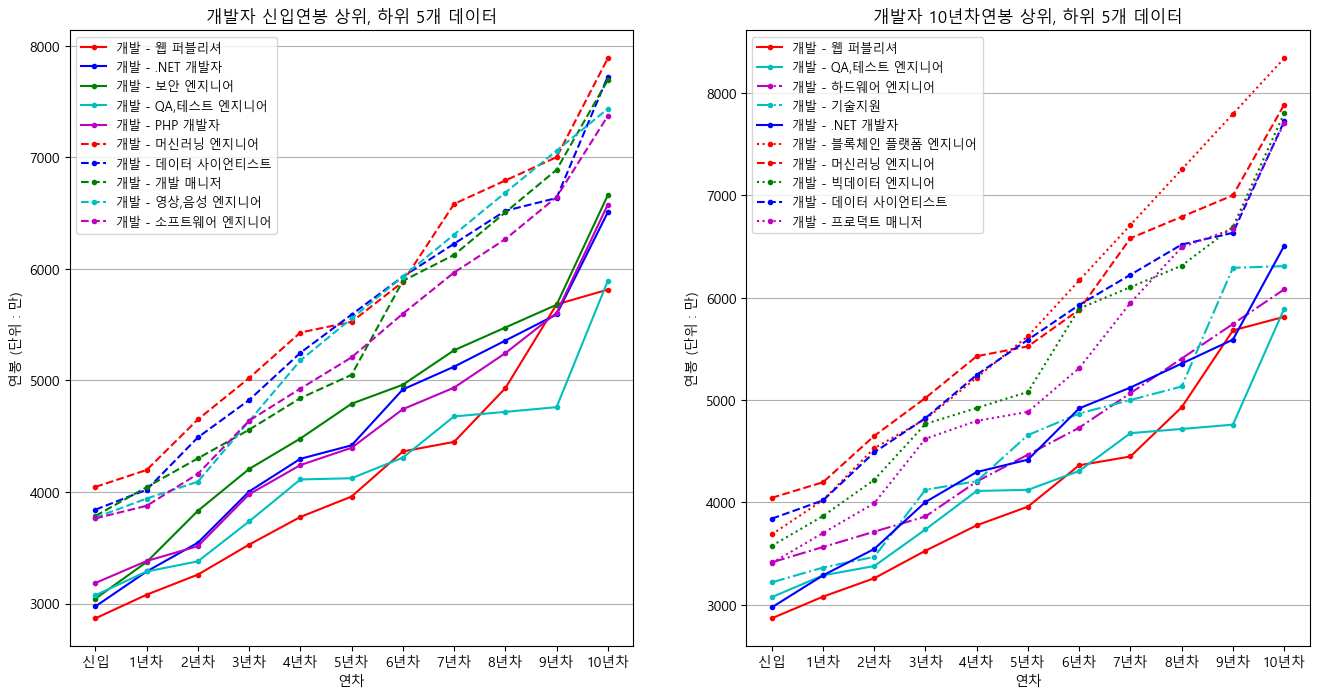

In [271]:
newmoneylow = devdf.sort_values('신입')[:5] #개발자 신입 연봉 금액의 하위 5개
newmoneylow.reset_index(inplace=True, drop=True) #for문을 위한 index 재정렬
newmoneyhigh = devdf.sort_values('신입', ascending=False)[:5] #개발자 신입 연봉 금액의 상위 5개
newmoneyhigh.reset_index(inplace=True, drop=True) #for문을 위한 index 재정렬
oldmoneylow = devdf.sort_values('10년차')[:5] #개발자 10년차 연봉 금액의 하위 5개
oldmoneylow.reset_index(inplace=True, drop=True) #for문을 위한 index 재정렬
oldmoneyhigh = devdf.sort_values('10년차', ascending=False)[:5] #개발자 10년차 연봉 금액의 상위 5개
oldmoneyhigh.reset_index(inplace=True, drop=True) #for문을 위한 index 재정렬


#아래 데이터를 보고 두 그래프의 중복된 값들은 같은 색과 스타일로 지정, 나머지는 다 다르게
color_and_line = ['r.-', 'b.-', 'g.-', 'c.-', 'm.-', 'r.--', 'b.--', 'g.--', 'c.--', 'm.--']
color_and_line2 = ['r.-', 'c.-', 'm-..', 'c-..', 'b.-', 'r:.', 'r.--', 'g:.', 'b.--', 'm:.']

plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
plt.title("개발자 신입연봉 상위, 하위 5개 데이터")
plt.xlabel('연차')
plt.ylabel('연봉 (단위 : 만)')
for k in range(len(newmoneylow)):
    lowlabels = newmoneylow.loc[k][0] + ' - ' + newmoneylow.loc[k][1] #직군 - 직무로 이어진 문자열 생성
    plt.plot(newmoneylow.iloc[:, 2:13].columns, newmoneylow.iloc[:, 2:13].loc[k], color_and_line[k], label=lowlabels)
for k in range(len(newmoneyhigh)):
    highlabels = newmoneyhigh.loc[k][0] + ' - ' + newmoneyhigh.loc[k][1] #직군 - 직무로 이어진 문자열 생성
    plt.plot(newmoneyhigh.iloc[:, 2:13].columns, newmoneyhigh.iloc[:, 2:13].loc[k], color_and_line[k+5], label=highlabels)
plt.legend(fontsize=9)
plt.grid(True, axis = 'y')

plt.subplot(1, 2, 2)
plt.title("개발자 10년차연봉 상위, 하위 5개 데이터")
plt.xlabel('연차')
plt.ylabel('연봉 (단위 : 만)')

for k in range(len(oldmoneylow)):
    lowlabels = oldmoneylow.loc[k][0] + ' - ' + oldmoneylow.loc[k][1] #직군 - 직무로 이어진 문자열 생성
    plt.plot(oldmoneylow.iloc[:, 2:13].columns, oldmoneylow.iloc[:, 2:13].loc[k], color_and_line2[k], label=lowlabels)
for k in range(len(oldmoneyhigh)):
    highlabels = oldmoneyhigh.loc[k][0] + ' - ' + oldmoneyhigh.loc[k][1] #직군 - 직무로 이어진 문자열 생성
    plt.plot(oldmoneyhigh.iloc[:, 2:13].columns, oldmoneyhigh.iloc[:, 2:13].loc[k], color_and_line2[k+5], label=highlabels)
plt.legend(fontsize=9)
plt.grid(True, axis = 'y')

plt.show()